# Automated TM project status & statistics report

This Jupyter notebook assumes it is executed in a google colab environment.

To update the data displayed in the notebook, use the _Runtime_ > _Run all_ menu item in the top menu bar. 

Running the notebook in _playground mode_ lets you execute the notebook to update the data, without making any changes permanent changes. When you close the browser tab, any changes you've made or results of running the notebook are discarded. You don't have to always run the notebook. 
See the _TM Data aquisition_ section below to check to timestamp of when the data was updated.

Run the notebook in regular mode (as opposed to playground mode) and save using _File_ > _Save_ to update the notebook data outputs so that the next person sees the updated view.



In [ ]:
#@title Install Colab runtime dependencies
# When executing this notebook, if you get the error
# > ModuleNotFoundError: No module named 'tasking_manager_client'
# Uncomment and run this line to install the missing dependency:
!python3 -m pip install -q git+https://github.com/jarmokivekas/tasking-manager-client-python.git

In [ ]:
#@title TM Data aquisition {display-mode: "form"}
textSearch = "covid" #@param {type:"string"}
projectStatuses = "ARCHIVED,PUBLISHED,DRAFT" #@param {type:"string"}

import pandas as pd
import tasking_manager_client as tm
from datetime import datetime
from IPython.display import HTML, Markdown

# make sure pandas doesn't truncate the dataframe when rendered
pd.set_option('display.max_rows', 500)


# for notebooks used for reporting, it's nice to
# timestamp of the data, since it can get old quickly
now = datetime.utcnow()
print(f'data last updated: {now} UTC')
print(f'tasking manager:   {tm.DEFAULT_INSTANCE_API}')
print(f'search keyword:    {textSearch}')


# Collect the project data from the API
# concatenate paginated API results into one dataframe
result = pd.concat(tm.v2.project_search(textSearch=textSearch, projectStatuses=projectStatuses), ignore_index=True);
# search API pagination sometimes returns the same project more than once (due to pageintaion cacheing)
result = result.drop_duplicates(subset='projectId');

# The country column is has the country string wrapped in a 1-length list, convert it to a plain string
result['country'] = result['country'].apply(lambda val: val[0] if isinstance(val, list) else val)

# sort rows to be more reader friendly. Any number of columns can be given in
# the list for hierarchical sorting 
display_result = result.sort_values(by=['country','projectId' ])
# Many of the coulmns are unnecessary for an overview, we select only a few of them
display_result = display_result[['projectId', 'name', 'country', 'percentMapped','percentValidated', 'mapperLevel','status', 'priority']]


# Global statistics

This section contains basic statistics on all Tasking Manager projects found using a keyword search (Using the TM4 `project_search` api `textSearch` filter)


- Total number projects: 182
    - Drafts:    1
    - Published: 27 
    - Archived:  154
- Completed projects (100% mapped & validated): 94
- Average % mapped across all projects: 88.5 %
- Average % validated across all projects: 58.6 %


- Average completion rate: 0.48 projects/day

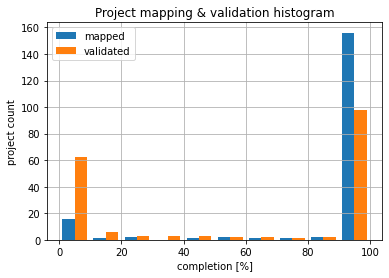

In [13]:
#@title Globat stats summary {display-mode: "form"}
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


def summarize_projects(df):
    """df: pandas dataframe of TM projects"""
    
    # number of projects completely mapped & validated
    completed = len(df[(df.percentMapped >= 99) & (df.percentValidated >= 99)])

    display(Markdown(
    f'''
- Total number projects: {len(df)}
    - Drafts:    {len(df[df.status=='DRAFT'])}
    - Published: {len(df[df.status=='PUBLISHED'])} 
    - Archived:  {len(df[df.status=='ARCHIVED'])}
- Completed projects (100% mapped & validated): {completed}
- Average % mapped across all projects: {df.percentMapped.mean():.1f} %
- Average % validated across all projects: {df.percentValidated.mean():.1f} %
'''))

summarize_projects(result)

# COVID-19 activation start
activation_date = datetime(2020,3,25)
activation_length = datetime.now() - activation_date
completed = len(result[(result.percentMapped >= 99) & (result.percentValidated >= 99)])

# average project completion rate during activation
completion_rate = completed / activation_length.days

display(Markdown(f'- Average completion rate: {completion_rate:.2f} projects/day'))


plt.figure()
plt.hist(
    [result['percentMapped'],result['percentValidated']],
    label=['mapped', 'validated'],
    bins=range(0,101,10))
plt.title('Project mapping & validation histogram')
plt.xlabel('completion [%]')
plt.ylabel('project count')
plt.legend();plt.grid()
plt.show()





## Pending Acrchival


The projects listed below have high (> 99 %) completion of both mapping and validation, and are in _Published_ status in Tasking Manager.
These are ready for a 2nd validation pass and eventually archiving

In [14]:
#@title
def pending_archival(df):
    """list complete but still published TM projects"""
    pending_archival = df[
        (df.percentMapped >= 99) & \
        (df.percentValidated >= 99) & \
        (df.status == 'PUBLISHED')
    ]
    display(Markdown(str(list(pending_archival['projectId']))))
pending_archival(result)

[1035, 1037, 2170, 4317, 4338, 4340, 4341, 4382, 8704, 8812]

# Projects by Country



In [15]:
#@title

def display_country(subset, country):

    # Add section heading
    display(Markdown(f'## {country}'))
    display(Markdown(f'---'))
    summarize_projects(subset)
    display(Markdown(f'---'))
    # Apply table styling and automatic colors
    styled = subset.style\
        .background_gradient(
            cmap=tm.style.hotosm_cmap(),
            subset=['percentMapped', 'percentValidated']
        )\
        .applymap(tm.style.format_priority, subset=['priority'])\
        .applymap(tm.style.format_status, subset=['status'])

    display(styled)

with pd.ExcelWriter('HOTOSM-covid-19-automatic.xlsx') as writer:

  for country in display_result.country.unique():
      subset = display_result[display_result.country == country]
      del subset['country']

      # export to excel sheet tab (long names truncated)
      subset.to_excel(
          writer,
          sheet_name=country[:30],
          index=False
      )

      # Display notebook output
      display_country(subset, country)

## Angola

---


- Total number projects: 3
    - Drafts:    1
    - Published: 2 
    - Archived:  0
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 15.0 %
- Average % validated across all projects: 0.3 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
115,3828,Okavango Wilderness Project,4,0,BEGINNER,PUBLISHED,LOW
116,3832,Luena: Okavango Wilderness Project,41,1,BEGINNER,PUBLISHED,LOW
117,3844,Cubango sub-basin: Okavango Wilderness Project,0,0,BEGINNER,DRAFT,LOW


## Botswana

---


- Total number projects: 178
    - Drafts:    0
    - Published: 25 
    - Archived:  153
- Completed projects (100% mapped & validated): 94
- Average % mapped across all projects: 90.1 %
- Average % validated across all projects: 59.9 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
56,668,Peace Corps’ Stomp Out Malaria - Kachikau,100,100,BEGINNER,ARCHIVED,LOW
58,670,Peace Corps’ Stomp Out Malaria - Kavimba,100,42,BEGINNER,ARCHIVED,LOW
59,705,Peace Corps Stomp Out Malaria - Mabele,100,100,BEGINNER,ARCHIVED,LOW
60,712,Peace Corps Stomp Out Malaria - Satau,100,4,BEGINNER,ARCHIVED,LOW
0,718,Peace Corps Stomp Out Malaria - Lesoma,100,100,BEGINNER,ARCHIVED,MEDIUM
1,760,Peace Corps Stomp Out Malaria - Pandamatenga Area,0,0,BEGINNER,ARCHIVED,MEDIUM
2,761,Peace Corps Stomp Out Malaria - Pandamatenga Area,100,75,BEGINNER,ARCHIVED,MEDIUM
3,824,Peace Corps Botswana- Rakops,100,96,BEGINNER,PUBLISHED,MEDIUM
61,881,Peace Corps Botswana - Ghanzi I,95,1,BEGINNER,ARCHIVED,LOW
62,882,Peace Corps Botswana - Ghanzi II,100,0,BEGINNER,ARCHIVED,LOW


## Zambia

---


- Total number projects: 1
    - Drafts:    0
    - Published: 0 
    - Archived:  1
- Completed projects (100% mapped & validated): 0
- Average % mapped across all projects: 24.0 %
- Average % validated across all projects: 4.0 %


---

,projectId,name,percentMapped,percentValidated,mapperLevel,status,priority
57,669,Peace Corps Stomp Out Malaria - Kazungula,24,4,BEGINNER,ARCHIVED,LOW


# Access the data as a spreadsheet

Besides displaying the data inline in this notebook, it is also exported as an exccel file to the Colab workspace. See the file "HOTOSM-covid-19-automatic.xlsx" in the colab sidebard. You may need to click the "Referesh" icon in the file tree to see the exported spreadsheet.


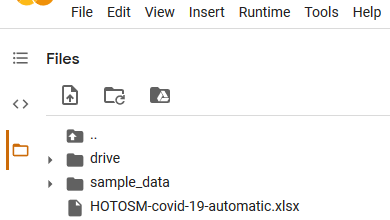